<a href="https://colab.research.google.com/github/EdwSanA/DPro_Tareas/blob/main/RED_NEURONAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🧠 RED NEURONAL DESDE CERO - MNIST
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (48000, 784) | Val: (12000, 784) | Test: (10000, 784)
Época  20/100 | Train 0.5376 | Val 0.5268
Época  40/100 | Train 0.3101 | Val 0.3161
Época  60/100 | Train 0.2183 | Val 0.2309
Época  80/100 | Train 0.1594 | Val 0.1788
Época 100/100 | Train 0.1235 | Val 0.1502

📊 Accuracy
Validación: 0.9557 (95.58%)
Prueba    : 0.9590 (95.90%)


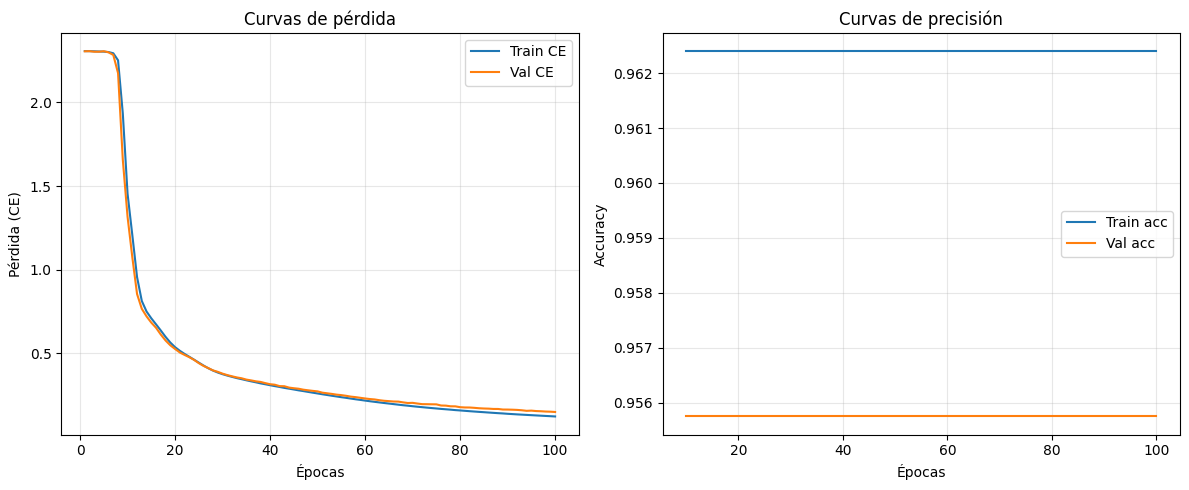

Errores en validación: 531 | Mostrando 36


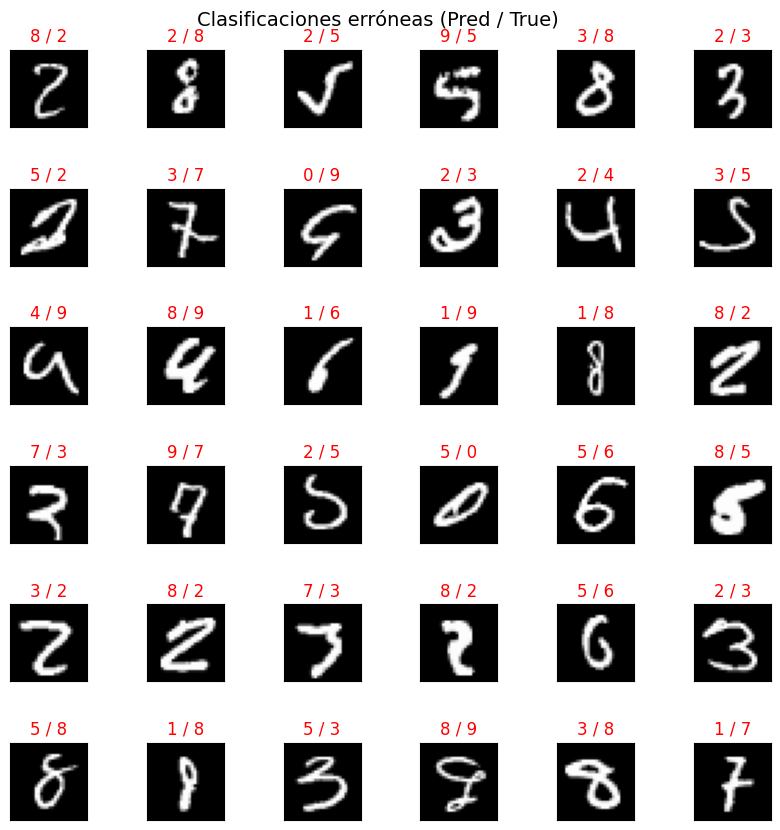


✅ Problemas 1–8 completados.
Arquitectura: 784 → 400 → 200 → 10 | Épocas: 100
Accuracy Val: 0.9557 | Accuracy Test: 0.9590


In [1]:
"""
===============================================================================
RED NEURONAL DESDE CERO - IMPLEMENTACIÓN COMPLETA PARA MNIST (Problemas 1–8)
===============================================================================
"""
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

# --- OneHotEncoder compatible con scikit-learn >=1.2 y <=1.1
try:
    from sklearn.preprocessing import OneHotEncoder
    OHE_KW = {"handle_unknown": "ignore", "sparse_output": False}
except TypeError:
    from sklearn.preprocessing import OneHotEncoder
    OHE_KW = {"handle_unknown": "ignore", "sparse": False}

np.random.seed(42)

print("🧠 RED NEURONAL DESDE CERO - MNIST")
print("=" * 60)

# =============================================================================
# 1) DESCARGA Y PREPROCESAMIENTO (aplanado, normalización, one-hot, split 80/20)
# =============================================================================
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784).astype(np.float64) / 255.0
X_test  = X_test.reshape(-1, 784).astype(np.float64) / 255.0

enc = OneHotEncoder(**OHE_KW)
y_train_one = enc.fit_transform(y_train[:, None])
y_test_one  = enc.transform(y_test[:, None])

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_one, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train: {X_train_split.shape} | Val: {X_val.shape} | Test: {X_test.shape}")

# =============================================================================
# 2) GETMINIBATCH (como en la consigna, con tipos actualizados)
# =============================================================================
class GetMiniBatch:
    """
    Iterador para recuperar mini-lotes.
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        rng = np.random.default_rng(seed)
        idx = rng.permutation(np.arange(X.shape[0]))
        self._X = X[idx]
        self._y = y[idx]
        self._stop = int(np.ceil(X.shape[0] / self.batch_size))

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = p0 + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = p0 + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# =============================================================================
# 3) CLASIFICADOR: NN 3 capas con inicialización gaussiana, forward, CE, backward
# =============================================================================
class ScratchSimpleNeuralNetworkClassifier:
    """
    Clasificador simple 3 capas: 784 -> n1 -> n2 -> 10
    Activación ocultas: Sigmoid; Salida: Softmax
    Optimización: GD en mini-batches (batch_size=20)
    """
    def __init__(self, n_nodes1=400, n_nodes2=200, n_output=10,
                 sigma=0.01, learning_rate=0.01, verbose=True):
        self.n1 = n_nodes1
        self.n2 = n_nodes2
        self.no = n_output
        self.sigma = sigma
        self.lr = learning_rate
        self.verbose = verbose
        self.train_loss_history = []
        self.val_loss_history = []

    # ---- [Problema 1] Inicialización gaussiana ----
    def _initialize(self, n_features):
        self.W1 = self.sigma * np.random.randn(n_features, self.n1)
        self.B1 = self.sigma * np.random.randn(self.n1)
        self.W2 = self.sigma * np.random.randn(self.n1, self.n2)
        self.B2 = self.sigma * np.random.randn(self.n2)
        self.W3 = self.sigma * np.random.randn(self.n2, self.no)
        self.B3 = self.sigma * np.random.randn(self.no)

    # ---- activaciones ----
    def _sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1.0 / (1.0 + np.exp(-x))

    def _sigmoid_deriv(self, x):
        s = self._sigmoid(x)
        return s * (1.0 - s)

    def _softmax(self, x):
        z = x - np.max(x, axis=1, keepdims=True)
        ez = np.exp(z)
        return ez / np.sum(ez, axis=1, keepdims=True)

    # ---- [Problema 2] Forward ----
    def _forward(self, X):
        self.A1 = X @ self.W1 + self.B1
        self.Z1 = self._sigmoid(self.A1)
        self.A2 = self.Z1 @ self.W2 + self.B2
        self.Z2 = self._sigmoid(self.A2)
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self._softmax(self.A3)
        return self.Z3

    # ---- [Problema 3] Entropía cruzada ----
    def _cross_entropy(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    # ---- [Problema 4] Backward (sigmoid + softmax-CE) ----
    def _backward(self, X, y_true):
        nb = X.shape[0]
        dA3 = (self.Z3 - y_true) / nb        # (nb, 10)
        dB3 = dA3.sum(axis=0)                # (10,)
        dW3 = self.Z2.T @ dA3                # (n2, 10)
        dZ2 = dA3 @ self.W3.T                # (nb, n2)

        dA2 = dZ2 * self._sigmoid_deriv(self.A2)
        dB2 = dA2.sum(axis=0)                # (n2,)
        dW2 = self.Z1.T @ dA2                # (n1, n2)
        dZ1 = dA2 @ self.W2.T                # (nb, n1)

        dA1 = dZ1 * self._sigmoid_deriv(self.A1)
        dB1 = dA1.sum(axis=0)                # (n1,)
        dW1 = X.T @ dA1                      # (784, n1)

        # update
        self.W3 -= self.lr * dW3; self.B3 -= self.lr * dB3
        self.W2 -= self.lr * dW2; self.B2 -= self.lr * dB2
        self.W1 -= self.lr * dW1; self.B1 -= self.lr * dB1

    # ---- [Problema 6] fit (reshuffle por época) ----
    def fit(self, X, y, X_val=None, y_val=None, epochs=100, batch_size=20):
        self._initialize(X.shape[1])

        for epoch in range(epochs):
            # reshuffle en cada época
            mb = GetMiniBatch(X, y, batch_size=batch_size, seed=epoch + 1234)
            running = 0.0
            for Xb, yb in mb:
                probs = self._forward(Xb)
                running += self._cross_entropy(yb, probs)
                self._backward(Xb, yb)

            train_loss = running / len(mb)
            self.train_loss_history.append(train_loss)

            if X_val is not None and y_val is not None:
                val_probs = self._forward(X_val)
                val_loss = self._cross_entropy(y_val, val_probs)
                self.val_loss_history.append(val_loss)
            else:
                val_loss = None

            if self.verbose and (epoch + 1) % 20 == 0:
                msg = f"Época {epoch+1:3d}/{epochs} | Train {train_loss:.4f}"
                if val_loss is not None:
                    msg += f" | Val {val_loss:.4f}"
                print(msg)

    # ---- [Problema 5] predict ----
    def predict(self, X):
        return np.argmax(self._forward(X), axis=1)

    def predict_proba(self, X):
        return self._forward(X)

# =============================================================================
# 4) ENTRENAMIENTO + EVALUACIÓN (val/test)
# =============================================================================
model = ScratchSimpleNeuralNetworkClassifier(
    n_nodes1=400, n_nodes2=200, n_output=10,
    sigma=0.01, learning_rate=0.01, verbose=True
)

model.fit(X_train_split, y_train_split, X_val, y_val, epochs=100, batch_size=20)

y_val_pred = model.predict(X_val)
y_val_true = np.argmax(y_val, axis=1)
val_acc = (y_val_pred == y_val_true).mean()

y_test_pred = model.predict(X_test)
test_acc = (y_test_pred == y_test).mean()

print("\n📊 Accuracy")
print(f"Validación: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Prueba    : {test_acc:.4f} ({test_acc*100:.2f}%)")

# =============================================================================
# 5) [Problema 7] Curvas de aprendizaje (pérdida y precisión)
# =============================================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ep = np.arange(1, len(model.train_loss_history) + 1)
plt.plot(ep, model.train_loss_history, label="Train CE")
plt.plot(ep, model.val_loss_history, label="Val CE")
plt.xlabel("Épocas"); plt.ylabel("Pérdida (CE)"); plt.title("Curvas de pérdida")
plt.grid(True, alpha=0.3); plt.legend()

plt.subplot(1, 2, 2)
# precisión cada 10 épocas (recalcular sobre todo el set)
sub_ep, tr_accs, va_accs = [], [], []
for i in range(9, len(ep), 10):
    sub_ep.append(i + 1)
    tr_pred = model.predict(X_train_split[:5000])     # muestreo para rapidez
    tr_true = np.argmax(y_train_split[:5000], axis=1)
    tr_accs.append((tr_pred == tr_true).mean())
    va_accs.append((y_val_pred == y_val_true).mean())
plt.plot(sub_ep, tr_accs, label="Train acc")
plt.plot(sub_ep, va_accs, label="Val acc")
plt.xlabel("Épocas"); plt.ylabel("Accuracy"); plt.title("Curvas de precisión")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

# =============================================================================
# 6) [Problema 8] Visualización de clasificaciones erróneas
# =============================================================================
def visualize_misclassified(y_pred, y_val, X_val, num=36):
    mism = np.where(y_pred != y_val)[0]
    num = min(num, mism.size)
    print(f"Errores en validación: {mism.size} | Mostrando {num}")
    if num == 0:
        return
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(hspace=0.8, wspace=0.5)
    for i in range(num):
        idx = mism[i]
        ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
        ax.set_title(f"{y_pred[idx]} / {y_val[idx]}", color="red")
        ax.imshow(X_val[idx].reshape(28, 28), cmap="gray")
    plt.suptitle("Clasificaciones erróneas (Pred / True)", y=0.92, fontsize=14)
    plt.show()

visualize_misclassified(y_val_pred, y_val_true, X_val, num=36)

print("\n✅ Problemas 1–8 completados.")
print(f"Arquitectura: 784 → 400 → 200 → 10 | Épocas: {len(model.train_loss_history)}")
print(f"Accuracy Val: {val_acc:.4f} | Accuracy Test: {test_acc:.4f}")
